(array([  7.,  26.,  59., 129., 183., 220., 203., 102.,  49.,  22.]),
 array([-0.07460496,  0.50400404,  1.08261304,  1.66122204,  2.23983104,
         2.81844004,  3.39704905,  3.97565805,  4.55426705,  5.13287605,
         5.71148505]),
 <a list of 10 Patch objects>)

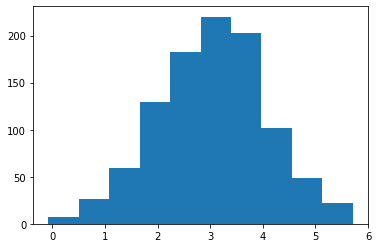

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
k1 = stats.skewnorm.rvs(0, 3, 1, size=1000)
plt.hist(k1)

(array([  7.,  46.,  84., 145., 214., 219., 162.,  87.,  31.,   5.]),
 array([3.16892624, 3.73532047, 4.3017147 , 4.86810892, 5.43450315,
        6.00089738, 6.56729161, 7.13368584, 7.70008007, 8.2664743 ,
        8.83286853]),
 <a list of 10 Patch objects>)

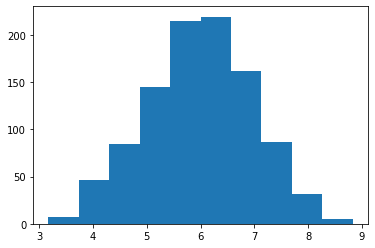

In [ ]:
k2 = stats.skewnorm.rvs(0, 6, 1, size=1000)
plt.hist(k2)

In [ ]:
!pip3 install tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 47kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip3 install tensorflow-quantum

     |████████████████████████████████| 5.9MB 4.6MB/s 
     |████████████████████████████████| 5.6MB 33.2MB/s 
     |████████████████████████████████| 1.6MB 43.3MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
x_train= np.asarray(list(k1[:200])+ list(k2[:200]))
y_train= np.asarray(list(0 for _ in range(200))+ list(1 for _ in range(200)))
x_test= np.asarray(list(k1[200:])+ list(k2[200:]))
y_test= np.asarray(list(0 for _ in range(800))+ list(1 for _ in range(800)))


In [ ]:
x_train = np.array([[x] for x in x_train])
y_train = np.array([[np.float64(x)] for x in y_train])
x_test = np.array([[x] for x in x_test])
y_test = np.array([[np.float64(x)] for x in y_test])

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

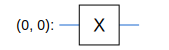

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)


In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 10
BATCH_SIZE = 1

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=1,
      epochs=EPOCHS,
      shuffle=True,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0019 - val_loss: 1.0000
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0014 - val_loss: 1.0000
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0014 - val_loss: 1.0000
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0011 - val_loss: 1.0000
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0015 - val_loss: 1.0000
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0023 - val_loss: 1.0000
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0012 - val_loss: 1.0000
Epoch 8/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0011 - val_loss: 1.0000
Epoch 9/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0018 - val_loss: 1.0000
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: 1.0000


In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(1, )),
                                tf.keras.layers.Dense(32, activation='relu'), 
                                tf.keras.layers.Dense(2, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  
                loss= 'sparse_categorical_crossentropy',
                metrics=['accuracy']  )
model.fit(x_train,
                      y_train,
                      shuffle=True,
                      epochs=100,
                      verbose=1,
                      batch_size=1,
                      #callbacks=callbacks_list,
                      #validation_split=0.3
                      )

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.9470 - accuracy: 0.5000
Epoch 2/100
400/400 [==============================] - 1s 1ms/step - loss: 0.7394 - accuracy: 0.3675
Epoch 3/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6786 - accuracy: 0.5000
Epoch 4/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6608 - accuracy: 0.5000
Epoch 5/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6526 - accuracy: 0.5000
Epoch 6/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6447 - accuracy: 0.5000
Epoch 7/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6371 - accuracy: 0.5000
Epoch 8/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6294 - accuracy: 0.5050
Epoch 9/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6221 - accuracy: 0.5175
Epoch 10/100
400/400 [==============================] - 0s 1ms/step - loss: 0.6142 - accura

In [ ]:
err, acc = model.evaluate(x_test, y_test, batch_size=1)
print('predict err=%s, acc=%s'%(err, acc))

1600/1600 [==============================] - 1s 768us/step - loss: 0.2048 - accuracy: 0.9275
predict err=0.2048022300004959, acc=0.9275000095367432
